# 5) Collocation Network

This notebook is part of **Applied NLP – Session 2: Phrases & Collocations**.

Overview:
- Visualize word collocations as a network graph where nodes are words and edges are bigram co-occurrences.
- Identify hub words (high degree) that co-occur frequently with many other words.
- Filter edges by frequency threshold to focus on strong collocations and reveal phrase structure.

Learning objectives:
- Represent bigram data as a network graph using NetworkX.
- Compute and visualize largest connected components to see collocation clusters.
- Interpret node degree as a measure of word centrality in phrasal patterns.
- Use network visualization to explore stylistic and thematic phrase structure.

Quick start:
1. Edit the `CONFIG` dictionary in the next code cell to point to your two plain-text books.
2. Adjust `min_ngram_count` to control edge density (higher = sparser graph, clearer hubs).
3. (Optional) Toggle `use_stopwords` to remove function words and focus on content-word collocations.
4. Run cells from top to bottom. The main outputs are saved to `../results/`.

Prerequisites:
- A Python environment with requirements.txt packages installed (pandas, matplotlib, networkx).
- The text files for the two works placed in `../data/`.

Notes and tips:
- The notebook uses the same robust preprocessing as notebooks 1-2 (strip_gutenberg, normalize quotes, etc.).
- Network graph: each word is a node; each bigram (a, b) creates an edge between nodes a and b weighted by co-occurrence count.
- Self-loops (edges from a word to itself) are filtered out for clarity.
- Largest connected component is extracted to avoid isolated word pairs cluttering the visualization.
- Node size scales with degree (number of connections); hub words appear larger.
- Edge width scales with weight (bigram count); frequent collocations appear thicker.
- Spring layout: positions nodes to minimize edge crossings and reveal structure.
- Consider removing stopwords first or filtering to content-words (nouns, verbs, adjectives) for cleaner networks.
- Compare per-book networks by running the same code on `text1` and `text2` separately to see shifts in collocation patterns.

**Goal:** Build and visualize a collocation network to explore phrase structure and identify hub words in your two selected works.


## 0. Setup & Configuration

- Fill the `CONFIG` paths for your two books (plain text).
- Toggle stopwords and thresholds as needed.


In [11]:
# ===== Imports & Config =====
import re, os, math, json, collections
from pathlib import Path
from collections import Counter

import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (9, 4.5)
plt.rcParams["axes.grid"] = True

CONFIG = {
    "book1_path": "../data/PetSemetary.txt",  # <-- change
    "book2_path": "../data/TheShining.txt",  # <-- change
    "language": "en",                # e.g. 'en','de','ru','el'
    "use_stopwords": False,          # toggle
    "min_ngram_count": 5,            # threshold (where applicable)
    "top_k": 20                      # top items to show
}

# Unicode-aware token regex: words with optional internal ' or -
WORD_RE = re.compile(r"[^\W\d_]+(?:[-'][^\W\d_]+)*", flags=re.UNICODE)

# Optional: supply your own stopwords set per language
STOPWORDS = set()


## 1. Load & Normalize Text

- Fix hyphenated line breaks (e.g., end-of-line hyphens).
- Normalize whitespace.
- Lowercase consistently.

Our books are a part of Project Gutenberg, which means there are some extra texts in each txt file to be cleaned.

In [12]:
# --- Robust Project Gutenberg boilerplate stripper --------------------------
_GB_START_MARKERS = [
    r"\*\*\*\s*START OF (THIS|THE) PROJECT GUTENBERG EBOOK",   # modern
    r"START OF (THIS|THE) PROJECT GUTENBERG EBOOK",             # fallback
    r"End of the Project Gutenberg(?:'s)? Etext",               # very old variants sometimes inverted
]
_GB_END_MARKERS = [
    r"\*\*\*\s*END OF (THIS|THE) PROJECT GUTENBERG EBOOK",      # modern
    r"END OF (THIS|THE) PROJECT GUTENBERG EBOOK",                # fallback
    r"End of Project Gutenberg(?:'s)? (?:Etext|eBook)",          # older variants
    r"\*\*\*\s*END: FULL LICENSE\s*\*\*\*",                      # license block end (older)
]

# Chapters (heuristic fallback if markers missing; English-centric but works often)
_CHAPTER_HINTS = [
    r"^\s*chapter\s+[ivxlcdm0-9]+[\.\: ]",   # CHAPTER I / Chapter 1
    r"^\s*book\s+[ivxlcdm0-9]+[\.\: ]",      # BOOK I etc.
    r"^\s*part\s+[ivxlcdm0-9]+[\.\: ]",
]

def strip_gutenberg(text: str) -> str:
    """
    Returns text between Gutenberg START and END markers (case-insensitive).
    If markers aren't found, heuristically trims to first chapter-like heading.
    Works for most EN/DE/RU/EL releases since headers are in English.
    """
    t = text.replace("\ufeff", "")  # strip BOM if present

    # Find START
    start_idx = None
    for pat in _GB_START_MARKERS:
        m = re.search(pat, t, flags=re.IGNORECASE)
        if m:
            # start AFTER the matched line
            start_idx = t.find("\n", m.end())
            if start_idx == -1:
                start_idx = m.end()
            break

    # Find END
    end_idx = None
    for pat in _GB_END_MARKERS:
        m = re.search(pat, t, flags=re.IGNORECASE)
        if m:
            # end BEFORE the matched line
            end_idx = m.start()
            break

    if start_idx is not None and end_idx is not None and end_idx > start_idx:
        core = t[start_idx:end_idx]
    else:
        # Fallback: try to start at first chapter-like heading
        core = t
        for pat in _CHAPTER_HINTS:
            m = re.search(pat, core, flags=re.IGNORECASE | re.MULTILINE)
            if m:
                core = core[m.start():]
                break
        # And trim off the standard license tail if present
        for pat in _GB_END_MARKERS:
            m = re.search(pat, core, flags=re.IGNORECASE)
            if m:
                core = core[:m.start()]
                break

    # Remove license/contact blocks that sometimes sneak inside
    core = re.sub(r"\n\s*End of the Project Gutenberg.*", "", core, flags=re.IGNORECASE)
    core = re.sub(r"\*\*\*\s*START: FULL LICENSE\s*\*\*\*.*", "", core, flags=re.IGNORECASE | re.DOTALL)

    # Clean leftover cruft: URLs, repeated separators
    core = re.sub(r"https?://\S+", "", core)
    core = re.sub(r"[ \t]+\n", "\n", core)   # trailing spaces before newline
    core = re.sub(r"\n{3,}", "\n\n", core)   # collapse big blank blocks
    return core.strip()


In [13]:
def load_text(p: str) -> str:
    with open(p, "r", encoding="utf-8", errors="ignore") as f:
        return f.read()

def normalize_text(t: str) -> str:
    # 1) strip Gutenberg header/footer FIRST
    t = strip_gutenberg(t)
    # 2) join hyphenated line breaks (e.g., "won-\nderful")
    t = re.sub(r"-\s*\n", "", t)
    # 3) normalize whitespace
    t = re.sub(r"\s+", " ", t)
    return t

text1 = normalize_text(load_text(CONFIG["book1_path"]))
text2 = normalize_text(load_text(CONFIG["book2_path"]))

tokens1 = WORD_RE.findall(text1.lower())
tokens2 = WORD_RE.findall(text2.lower())

if CONFIG["use_stopwords"]:
    tokens1 = [t for t in tokens1 if t not in STOPWORDS]
    tokens2 = [t for t in tokens2 if t not in STOPWORDS]

tokens = tokens1 + tokens2

len(tokens1), len(tokens2), len(tokens)

len(tokens), tokens[:12]


(310366,
 ['chapter',
  'thru',
  'chapter',
  'part',
  'ii',
  'the',
  'micmac',
  'burying',
  'ground',
  'chapter',
  'thru',
  'chapter'])

## 2. Build Bigram Graph

- Nodes: words
- Edges: bigrams (weight = co-occurrence count)
- Filter edges by `min_ngram_count` for clarity


In [14]:
import networkx as nx

bigrams_counts = Counter(zip(tokens, tokens[1:]))
min_c = CONFIG["min_ngram_count"]
edges = [(a,b,c) for (a,b), c in bigrams_counts.items() if c >= min_c and a != b]

G = nx.Graph()
for a,b,c in edges:
    G.add_edge(a, b, weight=c)

# Keep largest connected component for readability
if G.number_of_nodes() > 0:
    largest_cc = max(nx.connected_components(G), key=len)
    H = G.subgraph(largest_cc).copy()
else:
    H = G

len(G), len(H)

(1965, 1929)

## 3. Visualize Graph (spring layout)

## 3a. Filtered Network (Top Hubs Only)

For a clearer visualization, we aggressively filter to show only:
- **Top hub words** (highest degree nodes)
- **Strong connections** between these hubs only (edge weight ≥ 2× min_ngram_count)

This reveals the core collocation structure without overcrowding. You can adjust:
- `top_n_hubs` - how many hub words to show (default: 20)
- `min_edge_weight` - minimum connection strength to display (default: 2× min_ngram_count)

Filtered network: 50 nodes, 509 edges


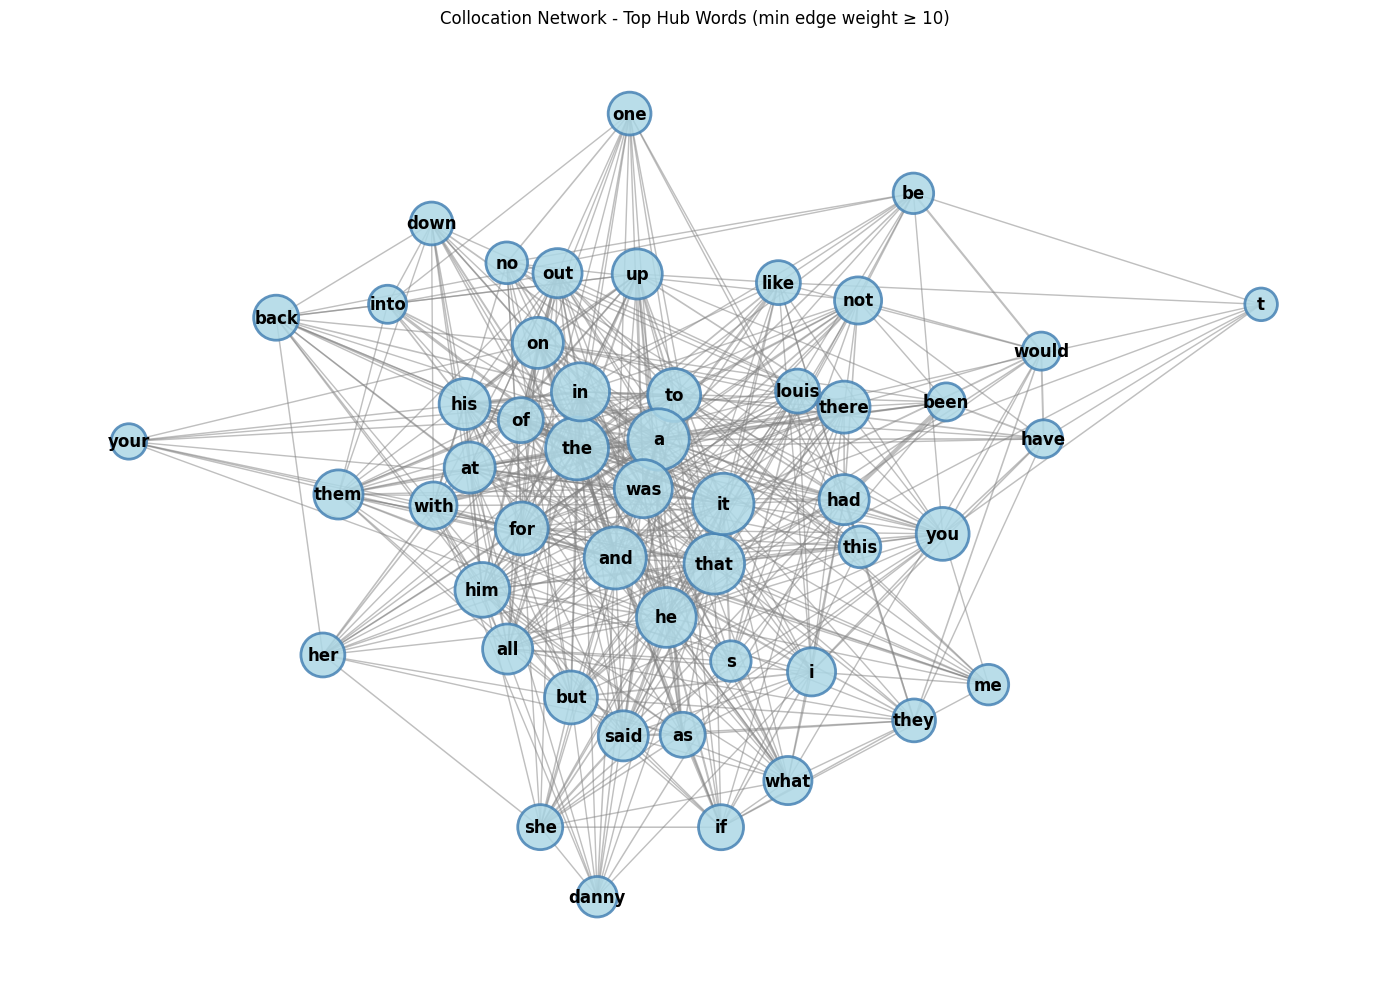

In [15]:
# Strategy: Show only strongest edges between high-degree nodes
# This creates a much cleaner, more readable network

# 1. Select top hubs by degree
top_n_hubs = 50  # start with top 20 hub words
deg = dict(H.degree())
top_hubs = set(sorted(deg, key=deg.get, reverse=True)[:top_n_hubs])

# 2. Filter to only include edges between these hubs with strong connections
# Only keep edges where BOTH nodes are hubs AND edge weight is high
edge_weights = [(u, v, d['weight']) for u, v, d in H.edges(data=True)]
edge_weights.sort(key=lambda x: x[2], reverse=True)

# Keep only edges where both nodes are in top hubs and weight is above threshold
min_edge_weight = CONFIG["min_ngram_count"] * 2  # stricter threshold for cleaner graph
filtered_edges = [
    (u, v, w) for u, v, w in edge_weights 
    if u in top_hubs and v in top_hubs and w >= min_edge_weight
]

# 3. Build clean filtered graph
H_filtered = nx.Graph()
for u, v, w in filtered_edges:
    H_filtered.add_edge(u, v, weight=w)

print(f"Filtered network: {H_filtered.number_of_nodes()} nodes, {H_filtered.number_of_edges()} edges")

# 4. Visualize - much cleaner now!
fig_filtered = plt.figure(figsize=(14,10))
pos = nx.spring_layout(H_filtered, k=0.8, iterations=100, seed=42)
deg_filtered = dict(H_filtered.degree())
wts_filtered = [H_filtered[u][v]["weight"] for u,v in H_filtered.edges()]

if wts_filtered and H_filtered.number_of_nodes() > 0:
    wmin, wmax = min(wts_filtered), max(wts_filtered)
    ew_filtered = [1 + 4*(w - wmin)/(wmax - wmin + 1e-9) for w in wts_filtered]
    
    # Draw nodes with size based on degree
    node_sizes = [200 + 50*deg_filtered[n] for n in H_filtered]
    nx.draw_networkx_nodes(H_filtered, pos, node_size=node_sizes, alpha=0.85, node_color='lightblue', edgecolors='steelblue', linewidths=2)
    nx.draw_networkx_edges(H_filtered, pos, width=ew_filtered, alpha=0.5, edge_color='gray')
    
    # Label all nodes - now readable!
    nx.draw_networkx_labels(H_filtered, pos, font_size=12, font_weight='bold')
    
    plt.title(f"Collocation Network - Top Hub Words (min edge weight ≥ {min_edge_weight})")
    plt.axis("off"); plt.tight_layout(); plt.show()
else:
    print(f"Graph too sparse. Try lowering min_edge_weight (currently {min_edge_weight}) or increase top_n_hubs.")

Can you now filter for stopwords and look again at the network?

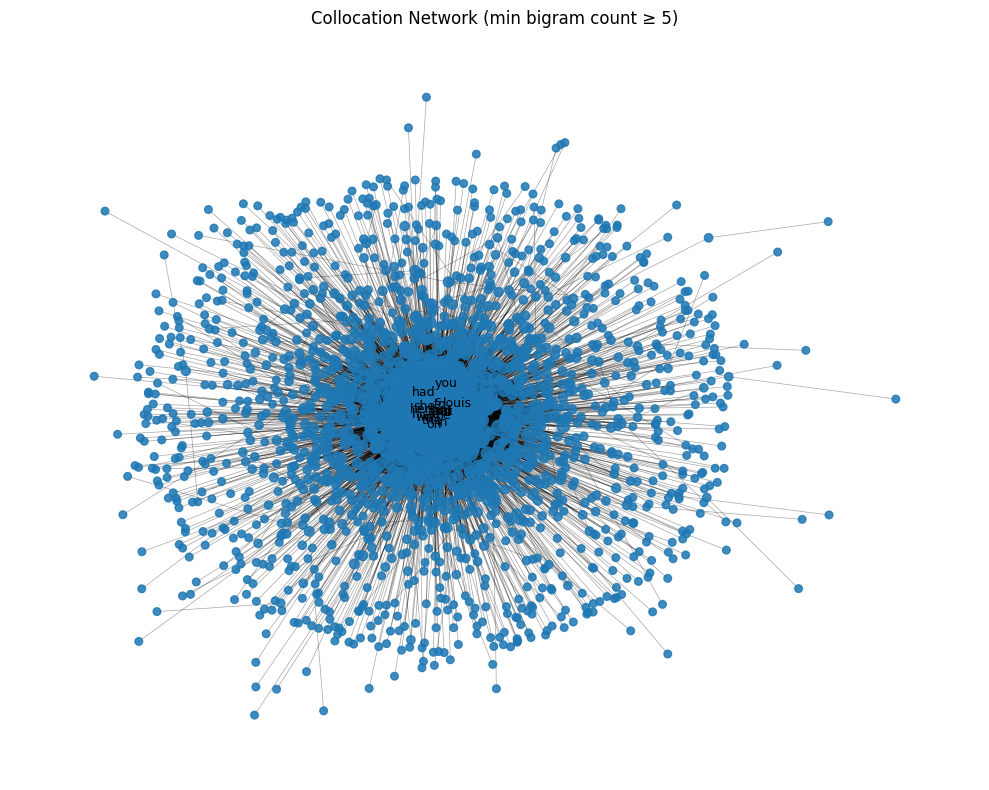

In [16]:
fig_network = plt.figure(figsize=(10,8))
pos = nx.spring_layout(H, k=0.25, iterations=50, seed=42)
deg = dict(H.degree())
wts = [H[u][v]["weight"] for u,v in H.edges()]

if wts:
    wmin, wmax = min(wts), max(wts)
    ew = [0.5 + 2.5*(w - wmin)/(wmax - wmin + 1e-9) for w in wts]
else:
    ew = []

nx.draw_networkx_nodes(H, pos, node_size=[24 + 6*deg[n] for n in H], alpha=0.85)
nx.draw_networkx_edges(H, pos, width=ew, alpha=0.35)

# Label a few hubs
top_nodes = sorted(deg, key=deg.get, reverse=True)[:20]
nx.draw_networkx_labels(H, pos, labels={n:n for n in top_nodes}, font_size=9)
plt.title(f"Collocation Network (min bigram count ≥ {min_c})")
plt.axis("off"); plt.tight_layout(); plt.show()

## 4. Notes

- Consider removing stopwords or filtering to content-words first.
- Compare per-book networks to see shifts in phrase structure.


## 5. Reflection (Answer in your repo's README or below)

- Which results matched your reading intuition?
- What surprised you?
- If you toggled preprocessing (stopwords on/off), what changed?
- Compare across the two works: are the patterns stable?

## 6. Export (tables/figures)

This cell saves outputs into the `../results/` folder so you can add them to your report.


In [17]:
Path("../results").mkdir(exist_ok=True)

# Save full network figure
try:
    fig_network.savefig("../results/collocation_network_full.png", dpi=200, bbox_inches="tight")
except NameError:
    pass

# Save filtered network figure (clearer, more readable)
try:
    fig_filtered.savefig("../results/collocation_network_filtered.png", dpi=200, bbox_inches="tight")
except NameError:
    try:
        plt.savefig("../results/collocation_network_filtered.png", dpi=200, bbox_inches="tight")
    except Exception:
        pass